In [1]:
import numpy as np
import cv2

import os
from os import path as osp
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from model.net import DGCNet
import datetime

In [2]:
class DeNormalize:
    '''
    Removes normalization using the mean, std specified
    '''
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor


# Image pre-processing constants
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

# Image de-normalization
restore_image = DeNormalize(mean, std)

# Prepare data for the network
dataset_transforms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

net = DGCNet(mask=True)
net.load_state_dict(torch.load(osp.join('pretrained_models',
                                        'dgcm',
                                        'checkpoint.pth'),
                               map_location=torch.device(device))['state_dict'])
net.eval()
net.to(device);

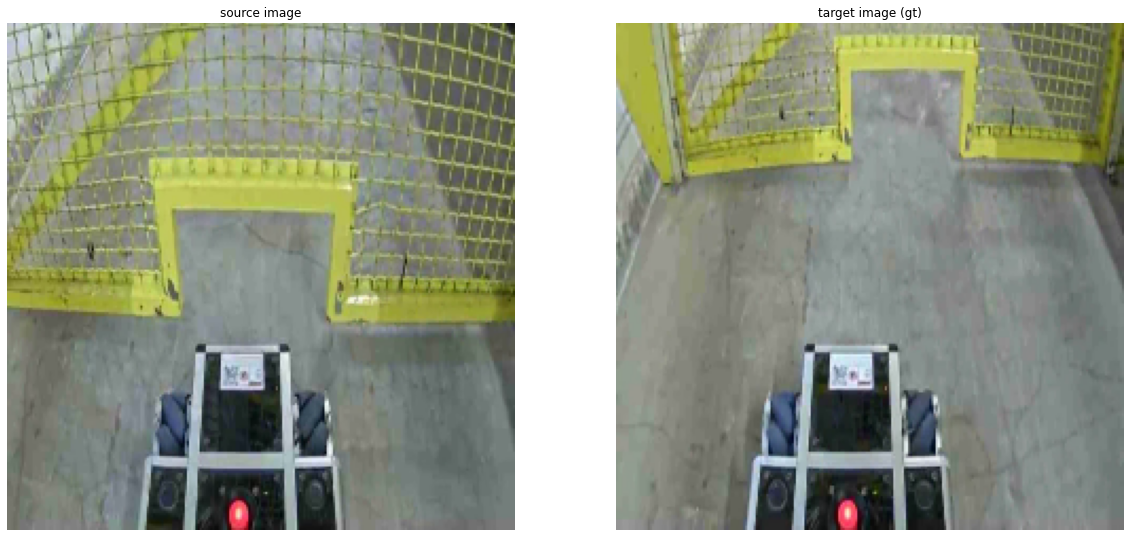

In [4]:
IMG_PATH = 'imgs/crossdoor'
IMG_SIZE_DGC = (240, 240)

img1 = cv2.resize(cv2.cvtColor(cv2.imread(osp.join(IMG_PATH, '0560.png'), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB),
                  IMG_SIZE_DGC)
img2 = cv2.resize(cv2.cvtColor(cv2.imread(osp.join(IMG_PATH, '0053.png'), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB),
                  IMG_SIZE_DGC)

plt.figure()
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(img1);
ax1.axis('off')
ax1.set_title('source image');

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(img2);
ax2.axis('off')
ax2.set_title('target image (gt)');


/home/usuario/.local/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


252


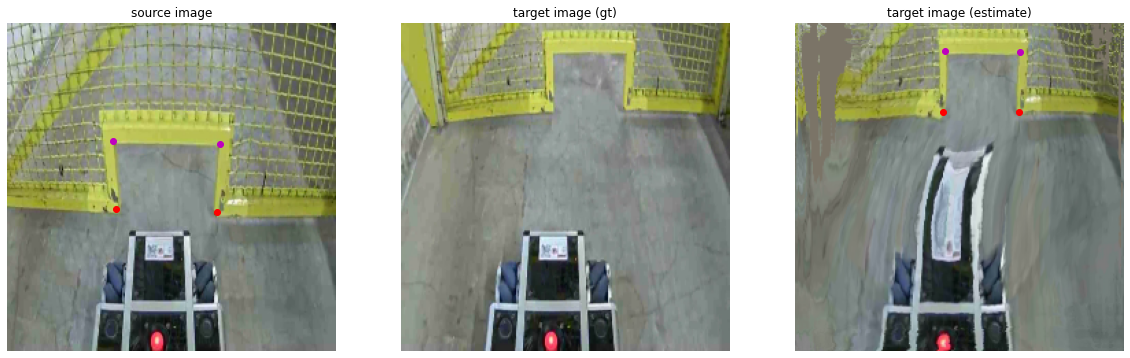

In [5]:
input1 = dataset_transforms(img1).unsqueeze(0)
input2 = dataset_transforms(img2).unsqueeze(0)
if use_cuda:
    input1 = input1.cuda()
    input2 = input2.cuda()
with torch.no_grad():
    a = datetime.datetime.now()
    # predict the warping grid between two images
    estimates_grid_pyr, match_mask = net(input1, input2)
    # warp the source image based on the estimates to be aligned with the target view
    warp_img = F.grid_sample(input1, estimates_grid_pyr[-1].permute(0, 2, 3, 1))
    b = datetime.datetime.now()
    delta = b - a
    print(int(delta.total_seconds() * 1000))

# Visualize the results
plt.figure()
ax1 = plt.subplot(1, 3, 1)
ax1.imshow(img1);
plt.plot([77,155],[86,88],'mo')
plt.plot([79,153],[136,138],'ro')
ax1.axis('off')
ax1.set_title('source image');

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(img2);
ax2.axis('off')
ax2.set_title('target image (gt)');

ax3 = plt.subplot(1, 3, 3)
ax3.imshow(restore_image(warp_img.squeeze()).permute(1, 2, 0).cpu().numpy());
plt.plot([109,164],[20,21],'mo')
plt.plot([108,163],[65,65],'ro')
ax3.axis('off')
ax3.set_title('target image (estimate)');


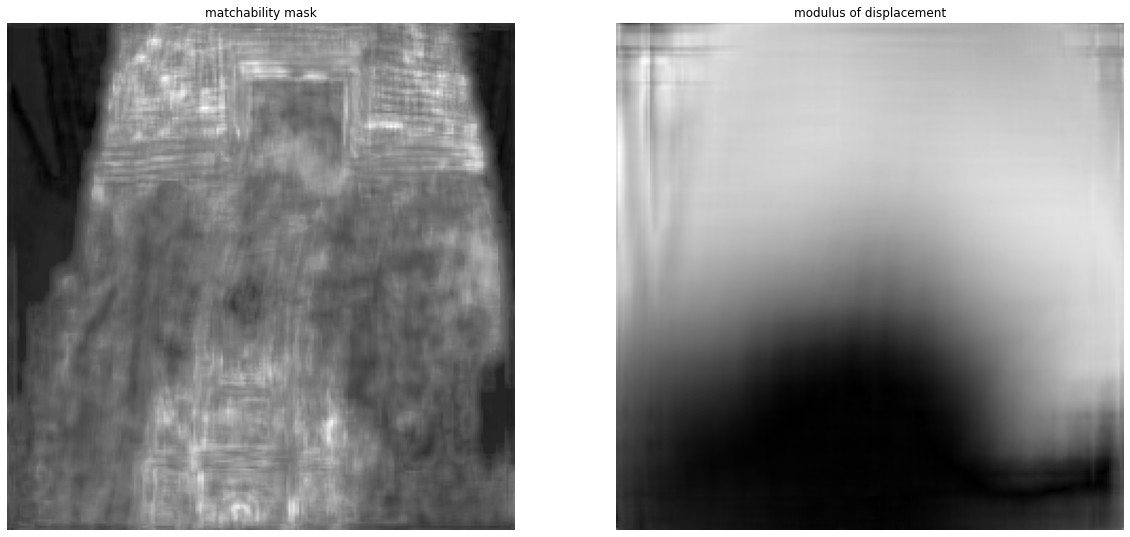

In [6]:
size = 240
md = np.zeros((size,size,))
u = np.zeros((size,size,))
v = np.zeros((size,size,))
mask = match_mask.permute(0, 2, 3, 1).cpu().numpy()[0]
flow = estimates_grid_pyr[-1].permute(0, 2, 3, 1).cpu().numpy()[0]

for i in range(size):
    for j in range(size):
        ws, hs = j * 2.0 / size - 1, i * 2.0 / size - 1
        md[i,j] = np.linalg.norm(flow[i,j]-np.array([ws,hs]))
        u[i,j] = ws-flow[i,j,0]
        v[i,j] = hs-flow[i,j,1]

plt.figure()
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(mask,cmap='gray');
ax1.axis('off')
ax1.set_title('matchability mask');

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(md,cmap='gray');
ax2.axis('off')
ax2.set_title('modulus of displacement');

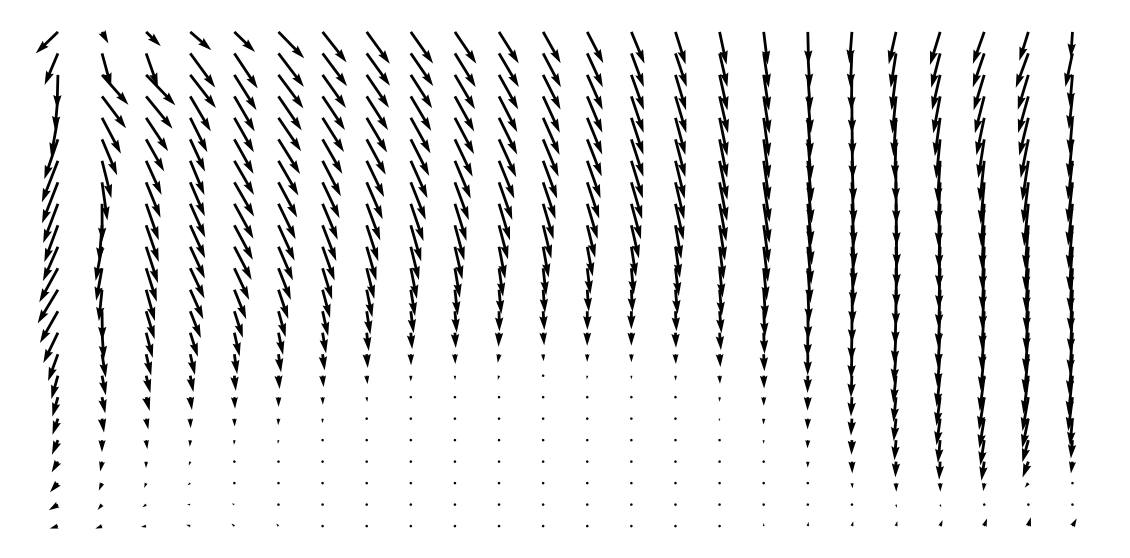

In [7]:
plt.quiver(u[::10,::10],v[::10,::10]); plt.axis('off'); plt.gca().invert_yaxis();

In [8]:
size = 240
# xs, ys = 77, 86
# xs, ys = 155, 88
# xs, ys = 79, 136
xs, ys = 153, 138
ws, hs = xs * 2.0 / size - 1, ys * 2.0 / size - 1

d = np.zeros((size,size,))
flow = estimates_grid_pyr[-1].permute(0, 2, 3, 1).cpu().numpy()[0]

for i in range(size):
    for j in range(size):
        d[i,j] = np.linalg.norm(flow[i,j]-np.array([ws,hs]))

# plt.imshow(d, cmap='gray');
yt, xt = np.unravel_index(np.argmin(d, axis=None), d.shape)
(xt, yt)

(163, 63)

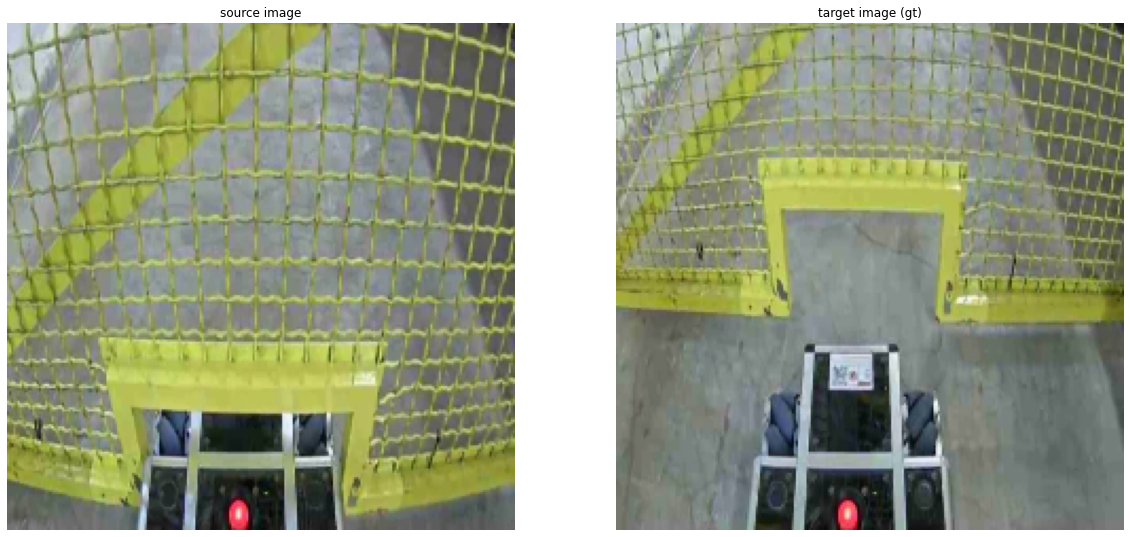

In [9]:
IMG_PATH = 'imgs/crossdoor'
IMG_SIZE_DGC = (240, 240)

img1 = cv2.resize(cv2.cvtColor(cv2.imread(osp.join(IMG_PATH, '0815.png'), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB),
                  IMG_SIZE_DGC)
img2 = cv2.resize(cv2.cvtColor(cv2.imread(osp.join(IMG_PATH, '0560.png'), cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB),
                  IMG_SIZE_DGC)

plt.figure()
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(img1);
ax1.axis('off')
ax1.set_title('source image');

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(img2);
ax2.axis('off')
ax2.set_title('target image (gt)');

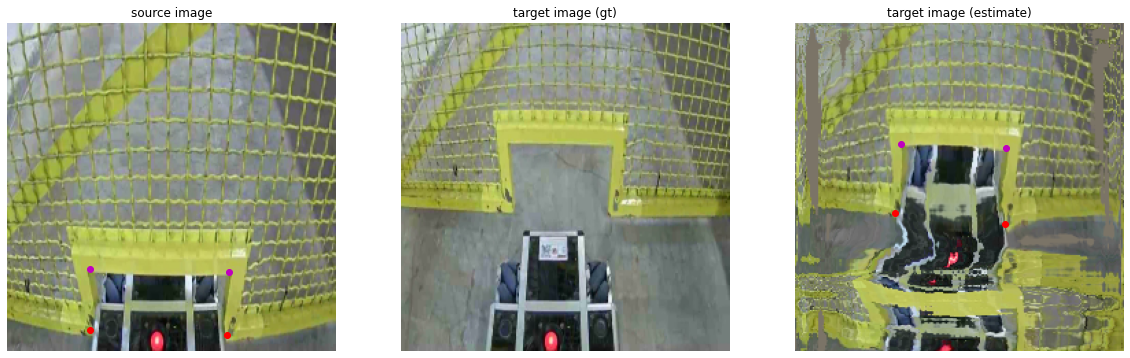

In [10]:
input1 = dataset_transforms(img1).unsqueeze(0)
input2 = dataset_transforms(img2).unsqueeze(0)
if use_cuda:
    input1 = input1.cuda()
    input2 = input2.cuda()
with torch.no_grad():
    # predict the warping grid between two images
    estimates_grid_pyr, match_mask = net(input1, input2)
    # warp the source image based on the estimates to be aligned with the target view
    warp_img = F.grid_sample(input1, estimates_grid_pyr[-1].permute(0, 2, 3, 1))


# Visualize the results
plt.figure()
ax1 = plt.subplot(1, 3, 1)
ax1.imshow(img1);
plt.plot([60,162],[180,182],'mo')
plt.plot([60,160],[224,228],'ro')
ax1.axis('off')
ax1.set_title('source image');

ax2 = plt.subplot(1, 3, 2)
ax2.imshow(img2);
ax2.axis('off')
ax2.set_title('target image (gt)');

ax3 = plt.subplot(1, 3, 3)
ax3.imshow(restore_image(warp_img.squeeze()).permute(1, 2, 0).cpu().numpy());
plt.plot([77,154],[88,91],'mo')
plt.plot([73,153],[139,147],'ro')
ax3.axis('off')
ax3.set_title('target image (estimate)');

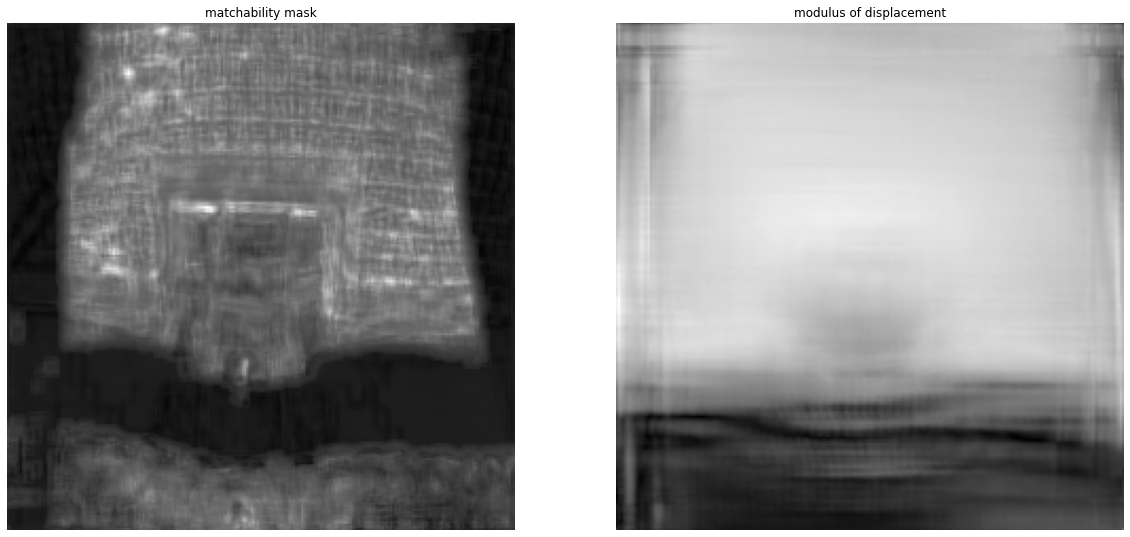

In [11]:
size = 240
md = np.zeros((size,size,))
u = np.zeros((size,size,))
v = np.zeros((size,size,))
mask = match_mask.permute(0, 2, 3, 1).cpu().numpy()[0]
flow = estimates_grid_pyr[-1].permute(0, 2, 3, 1).cpu().numpy()[0]

for i in range(size):
    for j in range(size):
        ws, hs = j * 2.0 / size - 1, i * 2.0 / size - 1
        md[i,j] = np.linalg.norm(flow[i,j]-np.array([ws,hs]))
        u[i,j] = ws-flow[i,j,0]
        v[i,j] = hs-flow[i,j,1]

plt.figure()
ax1 = plt.subplot(1, 2, 1)
ax1.imshow(mask,cmap='gray');
ax1.axis('off')
ax1.set_title('matchability mask');

ax2 = plt.subplot(1, 2, 2)
ax2.imshow(md,cmap='gray');
ax2.axis('off')
ax2.set_title('modulus of displacement');

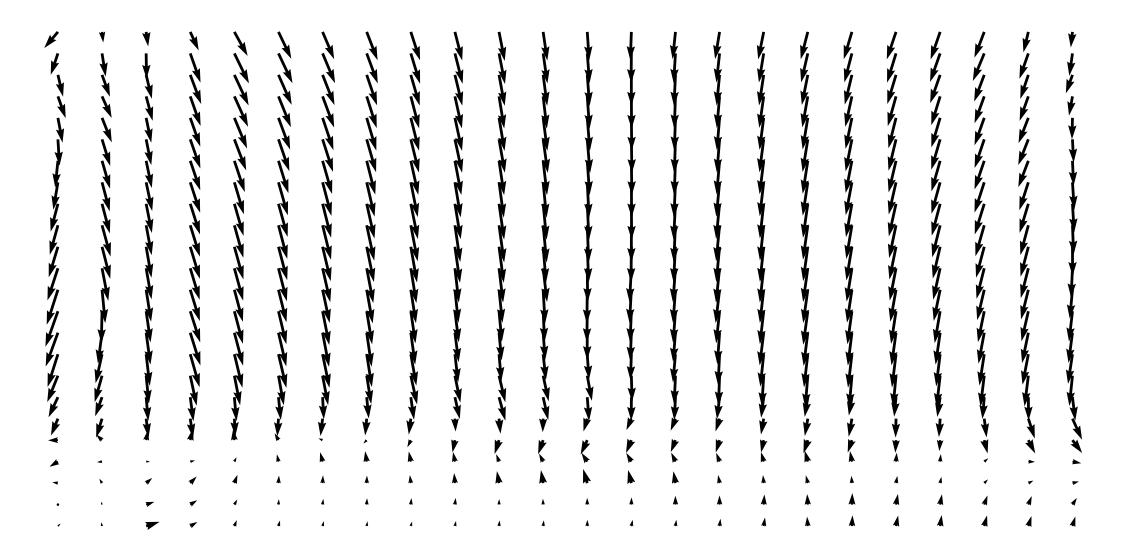

In [12]:
plt.quiver(u[::10,::10],v[::10,::10]); plt.axis('off'); plt.gca().invert_yaxis();

In [13]:
size = 240
# xs, ys = 60, 180
# xs, ys = 162, 182
# xs, ys = 60, 224
xs, ys = 160, 228
ws, hs = xs * 2.0 / size - 1, ys * 2.0 / size - 1

d = np.full((size,size,),float('inf'))
flow = estimates_grid_pyr[-1].permute(0, 2, 3, 1).cpu().numpy()[0]

for i in range(size):
    for j in range(size):
        if mask[i,j] > 0 and md[i,j] > 0.5:
            d[i,j] = np.linalg.norm(flow[i,j]-np.array([ws,hs]))

# plt.imshow(d, cmap='gray');
yt, xt = np.unravel_index(np.argmin(d, axis=None), d.shape)
(xt, yt)

(153, 147)